In [1]:
using Plots
using Statistics

In [2]:
#using DifferentialEquations
using Plots, Colors, LaTeXStrings
using Plots.Measures
font_title = Plots.font("Arial", 24)
font_axis = Plots.font("Arial", 12)
font_legend = Plots.font("Arial", 8)
pyplot(titlefont=font_title, guidefont = font_axis, legendfont = font_legend)

#Define different symbols used in the plotting
delta = latexstring("\$\\delta\$")
micro = latexstring("\$\\mu\$")
vt = latexstring("\$V_t\$")
nt = latexstring("\$N_t\$")
bt = latexstring("\$B_t\$")
wt = latexstring("\$W_t\$")
i_ach = latexstring("\$I_{ACh}\$")

v_color = :deepskyblue
n_color = :magenta
c_color = :green
a_color = :purple
b_color = :red
e_color = :blue
w_color = :gray

figure_path = "C:/users/mtarc/JuliaScripts/RetinalChaos/Notebooks/Figures"

"C:/users/mtarc/JuliaScripts/RetinalChaos/Notebooks/Figures"

## Table of contents:

### [0] Introduction to RetinalChaos.jl

### [1] Methods
#### [1.1] Voltage and Potassium gating components of the model
#### [1.2] Calcium and the Biochemical Reactions of the sAHP
#### [1.3] Acetylcholine Diffusion and Dynamics
#### [1.4] Gaussian White noise and dynamics

### _**[2] Analyzing Data Output of the model**_
#### [2.1] **Time Scale Analysis**
#### [2.2] Fitting Experimental Data (Patch)
#### [2.3] Fitting Experimental Data (Multi-electrode array)
#### [2.4] Fitting Experimental Data (Calcium Imageing) 

### [3] Experiments
#### [3.1] Dual Eye Correlations
#### [3.2] Recapitulations of older papers
#### [3.x] Dynamical Analysis

Evolution of each of the terms can be grouped into three time scales given by their time constants ($\tau$): 

    - fast (0.0-5.0ms) 
    - medium (0.5ms - 2s) 
    - slow (>5s) 

The fast components are the evolution of the membrane voltage $V_t$ ($\tau = 1.0$) and potassium relaxation $N_t$ ($\tau_N = 5ms$). Extracellular release of acetylcholine $E_t$ and calcium influx $C_t$ occur at intermediate time scales ($\tau_E = 540ms$ and $\tau_C = 2.0 s$ respectively). The components of the sAHP: cAMP decay ($A_t$) and TREK dephosphorylation ($B_t$) occur over a slower time scale ($\tau_A = 8.3s$ and $\tau_B = 8.3s$ respectively). Likewise this model has spikelets occurring on the order of 5ms intervals, bursts lasting of 0.5-2 seconds, and the sAHP which lasts 10-30s. These values are highly related. 

Along with this model, we are proposing that these three timescales can be calculated by physiological measurements. 
- By calculating;
    - the interspike interval within bursts, we can get an idea of the fast time scales 
    - medium time scales can being quantified by the average length of starburst bursts, 
    - the interburst interval can show the slow time scale. 

These measurements can be attained from patch-recordings, as well as calcium imaging. 
NOW WE NEED TO INCLUDE SOME DATA FROM THE MODEL and from the starburst data from Jordan. 
When compared to other models

In [3]:
import RetinalChaos: read_JSON, extract_dict
import RetinalChaos: T_sde
import RetinalChaos: SOSRI, SDEProblem, solve
import RetinalChaos: calculate_threshold, count_intervals, get_timestamps, max_interval_algorithim, timescale_analysis
import RetinalChaos: EnsembleProblem, EnsembleThreads, ensemble_func

## [2.1.a] Running the model simulation
- As in previous notebooks, we go through the steps to creating a new simulation

In [4]:
p = read_JSON("params.json") |> extract_dict;
u0 = read_JSON("conds.json") |> extract_dict;
dt = 1.0
tspan = (0.0, 300e3);
SDEprob = SDEProblem(T_sde, u0, tspan, p)
println("Time it took to simulate 200ms:")
@time SDEsol = solve(SDEprob, SOSRI(), abstol = 2e-2, reltol = 2e-2, maxiters = 1e7, saveat = dt); 
trace = Array(SDEsol)';

Time it took to simulate 200ms:
 10.787999 seconds (29.07 M allocations: 1.369 GiB, 5.32% gc time)


In [5]:
xticks = (SDEsol.t./1000, SDEsol.t)

([0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009  …  299.991, 299.992, 299.993, 299.994, 299.995, 299.996, 299.997, 299.998, 299.999, 300.0], [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  299991.0, 299992.0, 299993.0, 299994.0, 299995.0, 299996.0, 299997.0, 299998.0, 299999.0, 300000.0])

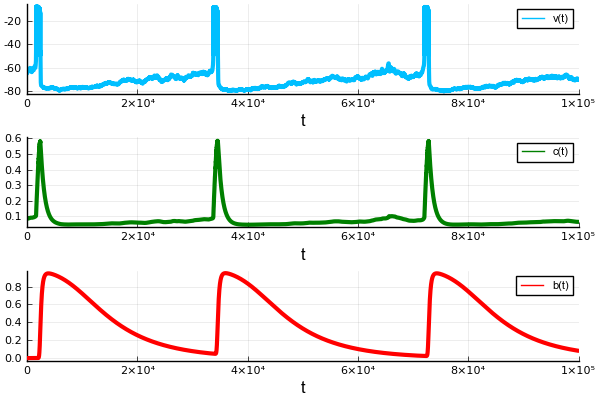

In [6]:
plot(SDEsol, vars = [:v, :c, :b], layout = grid(3,1),
    xlims = (0, 100e3),  lw = 3, c = [v_color c_color b_color]
)

### [2.1.b] Thresholding, Interspike Interval and Spike duration
    - We must first calculate the threshold with the calculate threshold function written into the package
    - We can apply the threshold like below. 
    - Then we can use the count intervals to get all the intervals between spikes. 

In [9]:
calculate_threshold(vm_arr::AbstractArray where T; Z::Int64 = 4) = sum(vm_arr)/length(vm_arr) + Z*std(vm_arr)

calculate_threshold (generic function with 1 method)

In [29]:
sim_thresh = calculate_threshold(trace[:,1])
println("The spiking threshold = $(round(sim_thresh, digits = 2)) mV")
spike_array = (trace[:,1] .> sim_thresh);
intervals = count_intervals(spike_array) .*dt;
println("$((intervals|>length)+1) spiking events have been detected")

The spiking threshold = -38.23 mV
303 spiking events have been detected


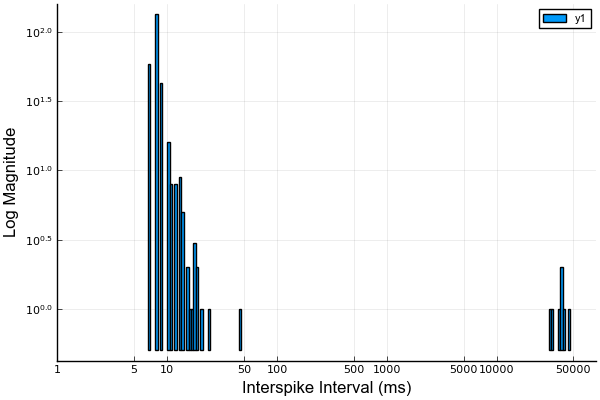

In [31]:
xstops = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000];
xticks = (log.(xstops), xstops);  
histogram(log.(intervals), yaxis = :log, xticks = xticks, ylabel = "Log Magnitude", xlabel = "Interspike Interval (ms)")

### We can use the function get_timestamps to collect all of the spike time stamps in the form of spike1 = (spike_start, spike_end)

In [34]:
timestamps = get_timestamps(spike_array; dt = dt);

In [35]:
durations = map(x -> x[2]-x[1], timestamps)
avg_spike_dur = sum(durations)/length(durations)
std_spike_dur = std(durations)
println("The average spike duration is $(round(avg_spike_dur, digits = 2)) ms +- $(round(std_spike_dur, digits = 2)) ms")

The average spike duration is 11.69 ms +- 0.47 ms


### [2.1.c] Burst Convolution, and Interburst Interval, and Burst Duration

- A function I have written classifies bursts according the max interval algorithim. This algorithim uses
    - Interspike Interval start (ISIstart) to measure the interval between spikes at the start of the burst 
    - Interspike Interval end (ISIend) to measure the interval between spikes at the end of a burst. 
    - The minimum interburst interval (IBImin) seperated proposed bursts. 
    - The minumum duration (DURmin) of a burst states how short the minumum burst can be
    - The minimum amount of spikes (SPBmin) that need to occur for a burst. 
- This algorithim utilizes the saveat interval defined above to give accurate timestamps. Most of the time the most important number will be the ISIstart and ISIend, with the IBI, Minimum duration and Spikes per burst all being well above the limits set here. 

In [36]:
burst_idxs, dur_list, spb_list, ibi_list = max_interval_algorithim(spike_array, verbose = true);

Timestamp 1: 1639.0 -> 2391.0, DUR 1: 752.0,  SPB 1: 36, IBI 1: 31385.0,
Timestamp 2: 33776.0 -> 34607.0, DUR 2: 831.0,  SPB 2: 38, IBI 2: 37441.0,
Timestamp 3: 72048.0 -> 72830.0, DUR 3: 782.0,  SPB 3: 37, IBI 3: 39660.0,
Timestamp 4: 112490.0 -> 113249.0, DUR 4: 759.0,  SPB 4: 37, IBI 4: 46495.0,
Timestamp 5: 159744.0 -> 160508.0, DUR 5: 764.0,  SPB 5: 37, IBI 5: 38319.0,
Timestamp 6: 198827.0 -> 199617.0, DUR 6: 790.0,  SPB 6: 37, IBI 6: 41242.0,
Timestamp 7: 240859.0 -> 241622.0, DUR 7: 763.0,  SPB 7: 37, IBI 7: 30481.0,
Timestamp  8: 272103.0 -> 272862.0, DUR 8: 759.0, SPB 8: 36, IBI 8: Unknown


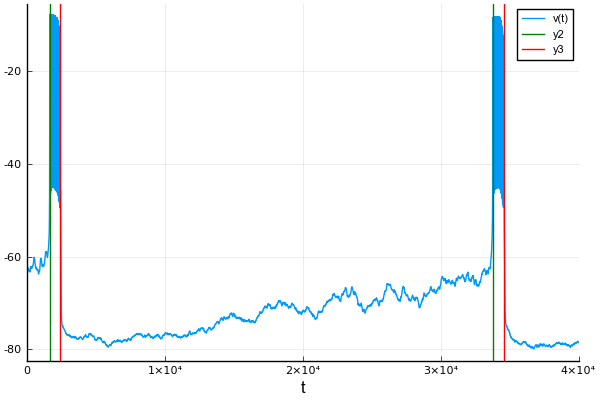

In [39]:
plot(SDEsol, vars = [:v], xlims = (0.0, 40e3))
vline!(map(x -> x[1], burst_idxs), c = :green)
vline!(map(x -> x[2], burst_idxs), c = :red)

In [12]:
avg_burst_dur = sum(dur_list)/length(dur_list);
std_burst_dur = std(dur_list);
println("The average burst duration is $(round(avg_burst_dur;digits = 2)) ms +- $(round(std_burst_dur;digits = 2)) ms")

The average burst duration is 774.56 ms +- 14.99 ms


In [13]:
avg_ibi = sum(ibi_list)/length(ibi_list)
std_ibi = std(ibi_list)
println("The average interburst interval is $(round(avg_ibi;digits = 2)) ms +- $(round(std_ibi;digits = 2)) ms")

The average interburst interval is 35308.75 ms +- 4712.95 ms


In [14]:
#Conducting the analysis in a single function you can use the imported function timescale_analysis
ts_analysis = timescale_analysis(trace[:,1]; dt = dt, mode = 2);

In [ ]:
histogram(ts_lattice[2])

### [2.1.d] Using Ensemble functions to alter variables or perform repeated trials. 

- We can use a parallelized Ensemble equations to perform repeated trials. Julia allows for us to run several trials independently but concurrently. 
- This can come in handy when we want to run the trials over many parameter points. 
- It will come in handy when trying to choose optimal parameters in the next notebook
- As an example we can vary the potassium excitability to observe how each quantifiable feature changes

In [26]:
n_sims = 50
par_sym = :g_Ca
par = findall(isequal(par_sym), Symbol.(T_sde.ps))[1]
#or 
#par = :none
p_range = LinRange(1.0, 20.0, n_sims)
println(par)

31


In [27]:
prob_func(prob, i, repeat) = ensemble_func(prob, i, repeat; pars = par, rng = p_range)
ensemble_prob = EnsembleProblem(SDEprob, prob_func = prob_func)

EnsembleProblem with problem SDEProblem

In [28]:
@time sim = solve(ensemble_prob, SOSRI(), abstol = 2e-2, reltol = 2e-2, maxiters = 1e7, saveat = dt, trajectories = n_sims, EnsembleThreads(), save_idxs = [1]);

 54.755549 seconds (111.13 M allocations: 5.966 GiB, 54.29% gc time)


In [29]:
#p = plot(xlims = (0, 60e3), size = (800, 800))
for (idx, traj) in enumerate(sim)
    val = p_range[idx]
    #plot!(p, traj, c = :delta, line_z = val, clim = (p_range[1], p_range[end]), legend = :none)
    #plot(p, )
end
#p

In [30]:
vars = [:v]
vals = []; spike_durs = []; burst_durs = []; ibis = []
for (idx, traj) in enumerate(sim)
    val = p_range[idx]
    #println("$idx -> $val")
    trace = Array(traj)'
    println(trace |> length)
    mean_spike_dur, std_spike_dur, mean_burst_dur, std_burst_dur, mean_ibi, std_ibi = timescale_analysis(trace[:,1]; dt = dt, mode = 1)
    push!(vals, val)
    push!(spike_durs, mean_spike_dur)
    push!(burst_durs, mean_burst_dur)
    push!(ibis, mean_ibi./1000)
end
p = plot(layout = grid(3,1))
plot!(p[1], vals, ibis, marker = :circle, markersize = 5, lw = 3.0, ylabel = "IBI (s)")
plot!(p[2], vals, burst_durs, marker = :circle, markersize = 5, lw = 3.0, ylabel = "Bursts (ms)")
plot!(p[3], vals, spike_durs, marker = :circle, markersize = 5, lw = 3.0, ylabel = "Spikes (ms)", xlabel = "$par_sym")

300001


BoundsError: BoundsError: attempt to access 0-element Array{Tuple,1} at index [0]